In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import pandas as pd
# import seaborn as sns

# sns.set()

In [3]:
import ee
ee.Initialize()

In [4]:
iniTime = '2003-01-01'
endTime = '2006-01-01'

geom = ee.Geometry.Point([37.3030,-0.1613])


In [5]:
def prep(img):
    nrescaled = img.select('ndvi').multiply(0.0001).updateMask(img.select('temporalFilled').Not())
    poorq = ee.Image(1).subtract(img.select('pctClear').multiply(0.01)).rename('qualityMasked')
    
    return nrescaled.addBands(poorq).set('system:time_start',img.get('system:time_start'))

rendvi = ee.ImageCollection('projects/servir-e-sa/rangelands/reNDVI').filterDate(iniTime,endTime)\
    .map(prep)



In [6]:
def prep(img):
    rescaled = img.expression('(n-100)/100',{'n':img.select('b1')})
    return rescaled.set('system:time_start',img.get('system:time_start')).rename('emodis')

emodis = ee.ImageCollection('users/servirscience/eModis').filterDate(iniTime,endTime)\
    .map(prep)


In [7]:
def eeRegion_to_dataFrame(result):
    df = pd.DataFrame(result[1:])
    df.columns = result[0]
    df["date"]= pd.to_datetime([t['value']*1e6 if type(t)==dict else t*1e6 for t in df["time"]] )
    df.index = df.date
    return df

In [8]:
scale = 250
result = rendvi.getRegion(geom,scale).getInfo()
rendviDf = eeRegion_to_dataFrame(result)

In [9]:
result = emodis.getRegion(geom,scale).getInfo()
emodisDf = eeRegion_to_dataFrame(result)

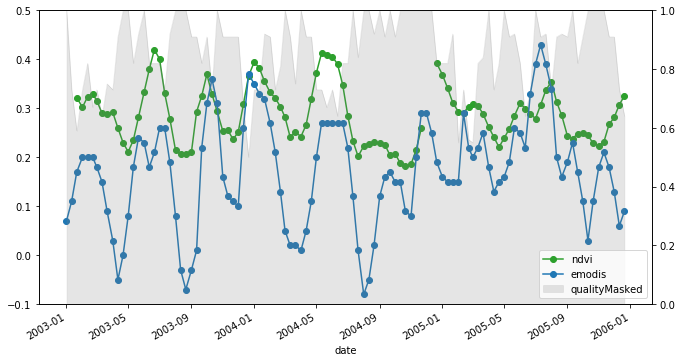

In [18]:
fig = plt.figure(figsize=(11,6))
axi = fig.add_subplot(111)

rendviDf['ndvi'].plot(ax=axi,marker='o',color='C2',zorder=10)
emodisDf['emodis'].plot(ax=axi,marker='o',color='C0',zorder=11)
axi.set_ylim(-0.1,0.5)

axj = axi.twinx()
rendviDf.plot.area(y='qualityMasked',color='gray',alpha=0.2,ax=axj,zorder=1,linewidth=0.5,legend=False)
axj.set_ylim(0,1)
fig.legend(loc="upper right", bbox_to_anchor=(1,0.2), bbox_transform=axi.transAxes)


plt.show()